In [1]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump, load
import pickle
import joblib

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

## Loading data

In this first step we will load our dataset that has been uploaded on my GitHub for easier process. From the dataset documentation found [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) we can see below are the list of column we have in our data:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 


Input variables:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):
21. y. has the client subscribed a term deposit? (binary: 'yes','no')

According to the dataset documentation, we need to remove the 'duration' column because in real-case the duration is only known after the label column is known. This problem can be considered to be 'data leakage' where predictors include data that will not be available at the time you make predictions.

In [2]:
# Load dataset
df_bank = pd.read_csv('./data/bank.csv')

print('Shape of dataframe:', df_bank.shape)
df_bank.head()

Shape of dataframe: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Class Distribution
Another important thing to make sure before feeding our data into the model is the class distribution of the data. In our case where the expected class are divided into two outcome, 'yes' and 'no', a class distribution of 50:50 can be considered ideal.

In [3]:
df_bank['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

## Describe columns
Understand statistics of both numerical and categorical columns 

In [4]:
numeric_columns = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [5]:
df_bank[numeric_columns].describe()

,age,balance,day,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,63.000000,854.000000,58.000000


#### The Balance column is suspicious since it has negative values

In [6]:
### Data manupulation
# Clean belance < 0 to be 0
df_bank.loc[df_bank['balance']<0, 'balance'] = 0
df_bank.loc[df_bank['balance']==0, 'balance']

5        0
17       0
23       0
30       0
42       0
        ..
11145    0
11147    0
11156    0
11160    0
11161    0
Name: balance, Length: 1462, dtype: int64

In [7]:
df_bank[numeric_columns].describe()

,age,balance,day,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1548.497223,15.658036,2.508421,51.330407,0.832557
std,11.913369,3213.199942,8.420740,2.722077,108.758282,2.292007
min,18.000000,0.000000,1.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,63.000000,854.000000,58.000000


In [8]:
df_bank[categorical_columns].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome
count,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2566,6351,5476,10994,5881,9702,8042,2824,8326


## Missing Values
Last thing to check before moving on is missing values. In some case our data might have missing values in some column, this can be caused some reasons such as human error. We can use the `is_null()` function from Pandas to check for any missing data and then use the `sum()` function to see the total of missing values in each column.

In [9]:
df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

From the result we can be assured that our data have no missing value and are good to go. In the case where you did have missing value in your data you can solve it by doing imputation or just remove the column altogether depending on your case. [Here](https://www.kaggle.com/dansbecker/handling-missing-values) is a good Kaggle course on how to handle missing value in dataset.

## Data preprocessing

In [10]:
# Select Features
feature = df_bank.drop('deposit', axis=1)

# Select Target
target = df_bank['deposit'].apply(lambda deposit: 1 if deposit == 'yes' else 0)

# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (8929, 16)
Shape of testing feature: (2233, 16)
Shape of training label: (8929,)
Shape of training label: (2233,)


## Scale Numeric Data

Next up, we will scale our numerical data to avoid outlier presence that can significantly affect our model. Using `StandardScaler()` function from sklearn we can scale each our columns that contains numerical data. The scaling will be done using the formula below:

<div align="center">$Z = \frac{X - U}{S}$</div>

*Where:*

*$Z:$ scaled value*

*$X:$ original value*

*$U:$ mean of the data*

*$S:$ standard deviation of the data*

## Encode Categorical Value

Same as the numerical data, we also need to pre-process our categorical data from words to number to make it easier for the computer to understands. To do this we will use `OneHotEncoder()` provided by sklearn. Basically it will transform a categorical column from this:

| marital | housing |
|----------|---------|
| single   | yes     |
| divorced | no      |
| married  | no      |

...into something like this...

| marital_single | marital_divorced | marital_married | housing_yes | housing_no |
|----------------|------------------|-----------------|-------------|------------|
| 1              | 0                | 0               | 1           | 0          |
| 0              | 1                | 0               | 0           | 1          |
| 0              | 0                | 1               | 0           | 1          |

In this code cell we will also encode our label column by replacing 'yes' and 'no' with 1 and 0 respectively. We can do this by applying simple lambda/in-line function on the column.

In [11]:
numeric_columns = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

scaler = StandardScaler()
one_hot_encoder = OneHotEncoder()


# Embeded both transformation into ColumnTransformer so that it could automatically transform data when having data
preprocessor = ColumnTransformer(transformers=[
    ('num', scaler, numeric_columns),
    ('cat', one_hot_encoder, categorical_columns)
])

# We use only X_train, not whole dataset to build params for StandardScaler to prevent data leakage.
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'balance', 'day', 'campaign', 'pdays',
                                  'previous']),
                                ('cat', OneHotEncoder(),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome'])])

In [12]:
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Modelling

After making sure our data is good and ready we can continue to building our model. In this notebook we will try to build 4 different models with different algorithm. In this step we will create a baseline model for each algorithm using the default parameters set by sklearn and after building all 4 of our models we will compare them to see which works best for our case.

To evaluate our model we will use the confusion matrix as our base for the evaluation.

<div align='center'><img src='https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png' height='250'></div>
where: TP = True Positive; FP = False Positive; TN = True Negative; FN = False Negative.

We will use 6 metrics below to evaluate models:

1. Accuracy: the proportion of true results among the total number of cases examined.
<div align='center'>$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$</div>
2. Precision: used to calculate how much proportion of all data that was predicted positive **was** actually positive.
<div align='center'>$Precision = \frac{TP}{TP+FP}$</div>
3. Recall: used to calculate how much proportion of actual positives is correctly classified.
<div align='center'>$Recall = \frac{TP}{TP+FN}$</div>
4. F1 score: a number between 0 and 1 and is the harmonic mean of precision and recall.
<div align='center'>$F1 = \frac{2TP}{2TP+FP+FN}$</div>
5. Cohen Kappa Score: Cohen's kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories.
<div align='center'>$\kappa = \frac{p_o-p_e}{1-p_e}$</div>
    where $p_o$ is the empirical probability of agreement on the label assigned to any sample (the observed agreement ratio), and $p_e$ is the expected agreement when both annotators assign labels randomly. $p_e$ is estimated using a per-annotator empirical prior over the class labels.
6. Area Under Curve (AUC): indicates how well the probabilities from the positive classes are separated from the negative classes

In this case we want to focus on the recall value of our model because in our problem we should try to predict as many actual positive as we can. Because a misclassification of customer who **actually** wanted to make a deposit can mean a lose opportunity/revenue.

Below we will define a helper function to evaluate each trained model and with the metrics mentioned above and save the score to a variable.

In [13]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

## Use 3 ML models
- Decision Tree
- Random forest
- NB

In [14]:
# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train_preprocessed, y_train)

# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test_preprocessed, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.6251679355127631
Precision: 0.609478672985782
Recall: 0.6020599250936329
F1 Score: 0.6057465850211964
Cohens Kappa Score: 0.2485378012599816
Area Under Curve: 0.6242059282120525
Confusion Matrix:
 [[753 412]
 [425 643]]


In [15]:
# Building Random Forest model 
rf = RandomForestClassifier(random_state=0, max_depth=8, n_estimators=300, min_samples_split=40, min_samples_leaf=60)
rf.fit(X_train_preprocessed, y_train)

# Evaluate Model
rf_eval = evaluate_model(rf, X_test_preprocessed, y_test)

# Print result
print('Performance on test dataset')
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Performance on test dataset
Accuracy: 0.7004030452306315
Precision: 0.7478260869565218
Recall: 0.5636704119850188
F1 Score: 0.6428190069407368
Cohens Kappa Score: 0.3934551097494081
Area Under Curve: 0.761386250020093
Confusion Matrix:
 [[962 203]
 [466 602]]


In [16]:
# Building Naive Bayes model 
nb = GaussianNB()
nb.fit(X_train_preprocessed, y_train)

# Evaluate Model
nb_eval = evaluate_model(nb, X_test_preprocessed, y_test)

# Print result
print('Accuracy:', nb_eval['acc'])
print('Precision:', nb_eval['prec'])
print('Recall:', nb_eval['rec'])
print('F1 Score:', nb_eval['f1'])
print('Cohens Kappa Score:', nb_eval['kappa'])
print('Area Under Curve:', nb_eval['auc'])
print('Confusion Matrix:\n', nb_eval['cm'])

Accuracy: 0.6815942678011644
Precision: 0.7560975609756098
Recall: 0.4934456928838951
F1 Score: 0.5971671388101983
Cohens Kappa Score: 0.352622455965517
Area Under Curve: 0.7421806432945941
Confusion Matrix:
 [[995 170]
 [541 527]]


In [17]:
# Building KNN model 
knn = KNeighborsClassifier()
knn.fit(X_train_preprocessed, y_train)

# Evaluate Model
knn_eval = evaluate_model(knn, X_test_preprocessed, y_test)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Cohens Kappa Score:', knn_eval['kappa'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.6865203761755486
Precision: 0.6965811965811965
Recall: 0.6104868913857678
F1 Score: 0.650698602794411
Cohens Kappa Score: 0.3686066933911124
Area Under Curve: 0.7316378936200993
Confusion Matrix:
 [[881 284]
 [416 652]]


## Model comparison
After building all of our model, we can now compare how well each model perform. To do this we will create two chart, first is a grouped bar chart to display the value of accuracy, precision, recall, f1, and kappa score of our model, and second a line chart to show the AUC of all our models.

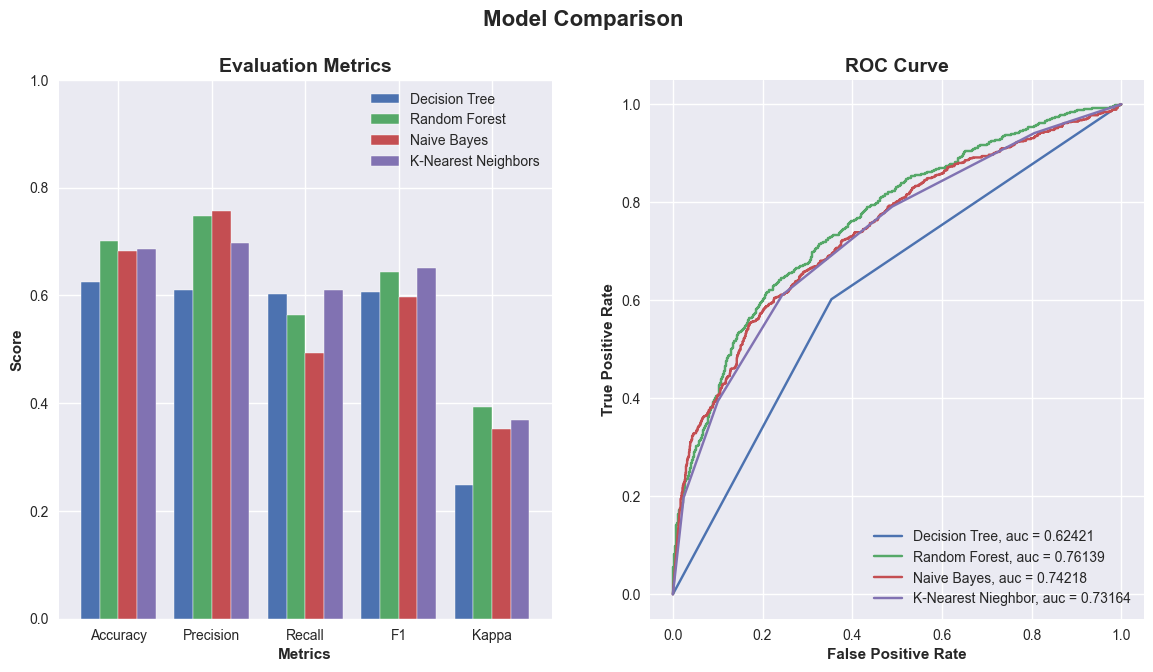

In [18]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1'], nb_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

## Prediction

In [19]:
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [20]:
feature

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure


In [21]:
len(X_train_preprocessed[0])

50

In [22]:
feature.iloc[0:2]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown


In [23]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])

df_bank['deposit_prediction'] = pipeline.predict(feature)
df_bank['deposit_prediction'] = df_bank['deposit_prediction'].apply(lambda x: 'yes' if x==1 else 'no')


df_bank.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,deposit_prediction
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,no
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,no
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,no
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,no
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,no
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes,no
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes,no
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes,no
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes,no
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes,no


In [24]:
# Check validity of the final model
df_bank[df_bank['deposit'] == df_bank['deposit_prediction']].shape

(8012, 18)

In [25]:
df_bank[df_bank['deposit'] != df_bank['deposit_prediction']].shape

(3150, 18)

In [26]:
## Save as a pickle file
filename= 'bank_deposit_classification.pkl'
joblib.dump(pipeline,open(filename, 'wb'))

In [27]:

import json
result = feature.iloc[0:2].to_json(orient="split")
parsed = json.loads(result)
print(json.dumps(parsed, indent=4))

{
    "columns": [
        "age",
        "job",
        "marital",
        "education",
        "default",
        "balance",
        "housing",
        "loan",
        "contact",
        "day",
        "month",
        "duration",
        "campaign",
        "pdays",
        "previous",
        "poutcome"
    ],
    "index": [
        0,
        1
    ],
    "data": [
        [
            59,
            "admin.",
            "married",
            "secondary",
            "no",
            2343,
            "yes",
            "no",
            "unknown",
            5,
            "may",
            1042,
            1,
            -1,
            0,
            "unknown"
        ],
        [
            56,
            "admin.",
            "married",
            "secondary",
            "no",
            45,
            "no",
            "no",
            "unknown",
            5,
            "may",
            1467,
            1,
            -1,
            0,
            "unkn